C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1401936638.py:52: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1401936638.py:110: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1401936638.py:110: DeprecationWarning: The class ``qiskit.primiti

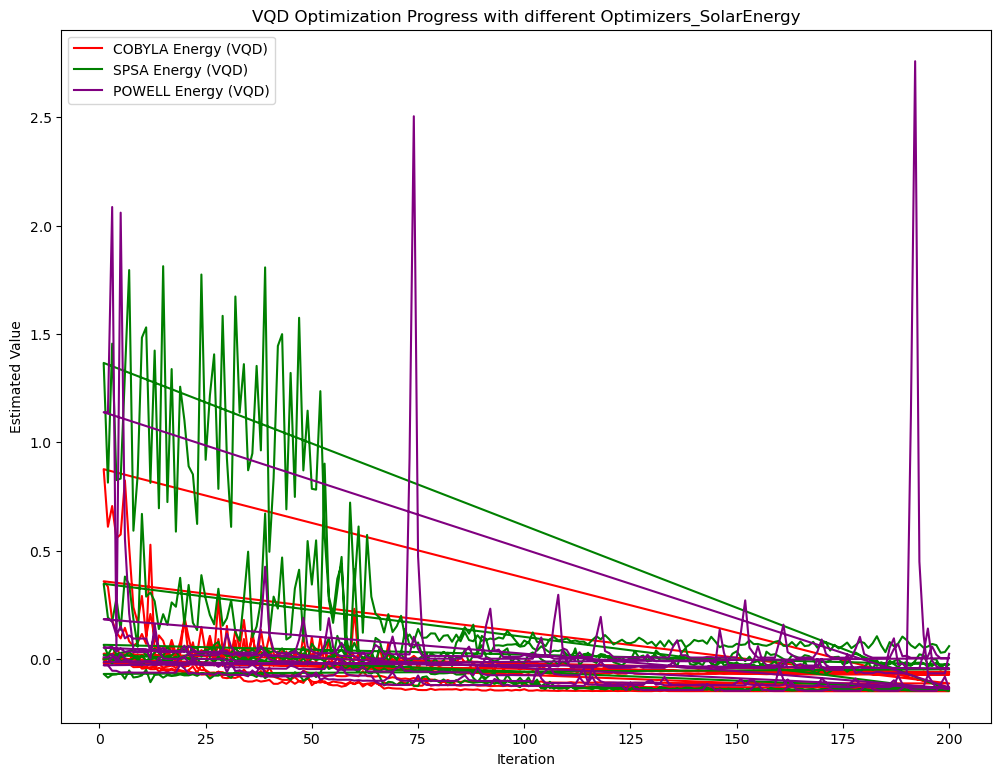

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance [internal resistance of 48v, 100Ah Lithium battery pack]
r_s = 18.15  # Internal resistance of two series connected panel [(V_oc-V_mpp)/(I_sc-I_mpp)]
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define the expanded Pauli operator based on the objective function
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)]) 
T_operator = SparsePauliOp.from_list([("IZII", 1)]) 
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)]) 
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)]) 

# Define the initial interaction operator
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use
optimizers = {'COBYLA': COBYLA(), 'SPSA': SPSA(), 'POWELL': POWELL()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
def callback(eval_count, params, value, meta, step, optimizer_name):
    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)

def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=4, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        #print("Optimized Parameters (raw):", optimized_params)  # Debugging output
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        #print("Optimized Parameters (fully flattened):", optimized_params)  # Debugging output after flattening
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'COBYLA': 'r', 'SPSA': 'g', 'POWELL': 'purple'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_solarenergy_deflation1.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = []
for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values):
    classical_power_outputs.append(power_output(V_oc, T, I_sc, G_theta))

# Print the final outputs
#for optimizer_name, eigenvalues in vqd_results.items():
    #quantum_max_power_output = eigenvalues[0] * impedance_factor  # Ground state energy for each optimizer
    #print(f"Maximized Power Output (Quantum with {optimizer_name} - Ground State): {quantum_max_power_output}")

#print("Maximized Power Output (Classical):", max(classical_power_outputs))

C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1851016621.py:52: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1851016621.py:110: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\1851016621.py:110: DeprecationWarning: The class ``qiskit.primiti

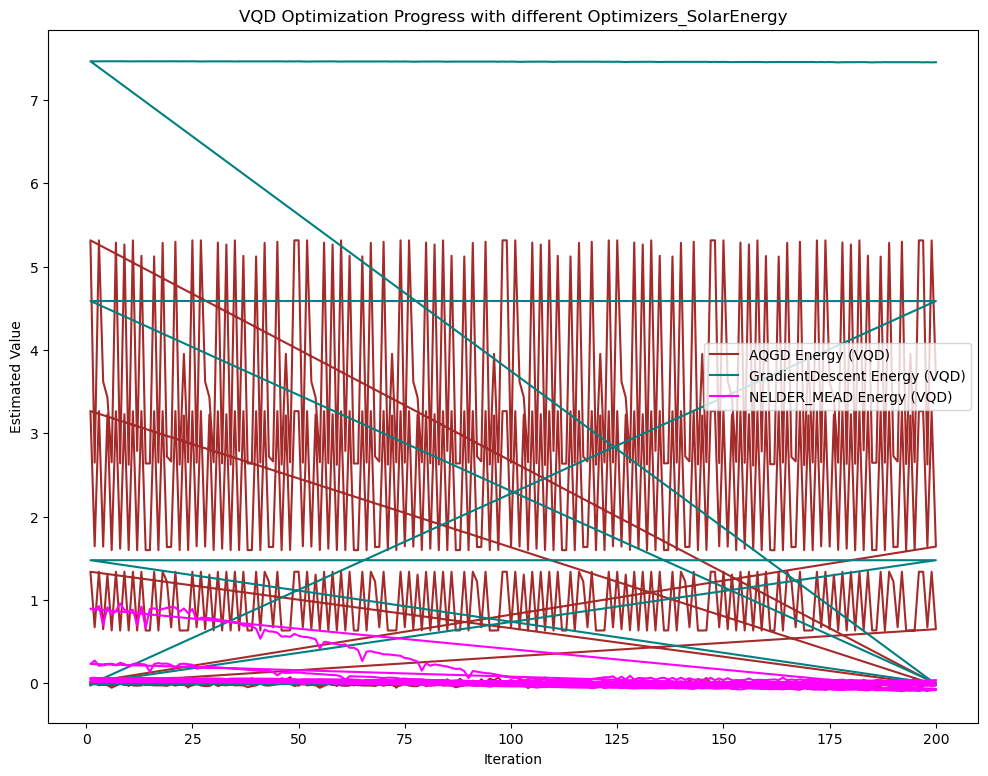

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import AQGD, GradientDescent, NELDER_MEAD
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance [internal resistance of 48v, 100Ah Lithium battery pack]
r_s = 18.15  # Internal resistance of two series connected panel [(V_oc-V_mpp)/(I_sc-I_mpp)]
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define the expanded Pauli operator based on the objective function
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)]) 
T_operator = SparsePauliOp.from_list([("IZII", 1)]) 
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)]) 
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)]) 

# Define the initial interaction operator
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use
optimizers = {'AQGD': AQGD(), 'GradientDescent': GradientDescent(), 'NELDER_MEAD': NELDER_MEAD()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
def callback(eval_count, params, value, meta, step, optimizer_name):
    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)

def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=4, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        #print("Optimized Parameters (raw):", optimized_params)  # Debugging output
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        #print("Optimized Parameters (fully flattened):", optimized_params)  # Debugging output after flattening
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'AQGD': 'brown', 'GradientDescent': 'teal', 'NELDER_MEAD': 'magenta'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_solarenergy_deflation2.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = []
for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values):
    classical_power_outputs.append(power_output(V_oc, T, I_sc, G_theta))

# Print the final outputs
#for optimizer_name, eigenvalues in vqd_results.items():
    #quantum_max_power_output = eigenvalues[0] * impedance_factor  # Ground state energy for each optimizer
    #print(f"Maximized Power Output (Quantum with {optimizer_name} - Ground State): {quantum_max_power_output}")

#print("Maximized Power Output (Classical):", max(classical_power_outputs))

C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\2269843940.py:52: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\2269843940.py:110: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_12004\2269843940.py:110: DeprecationWarning: The class ``qiskit.primiti

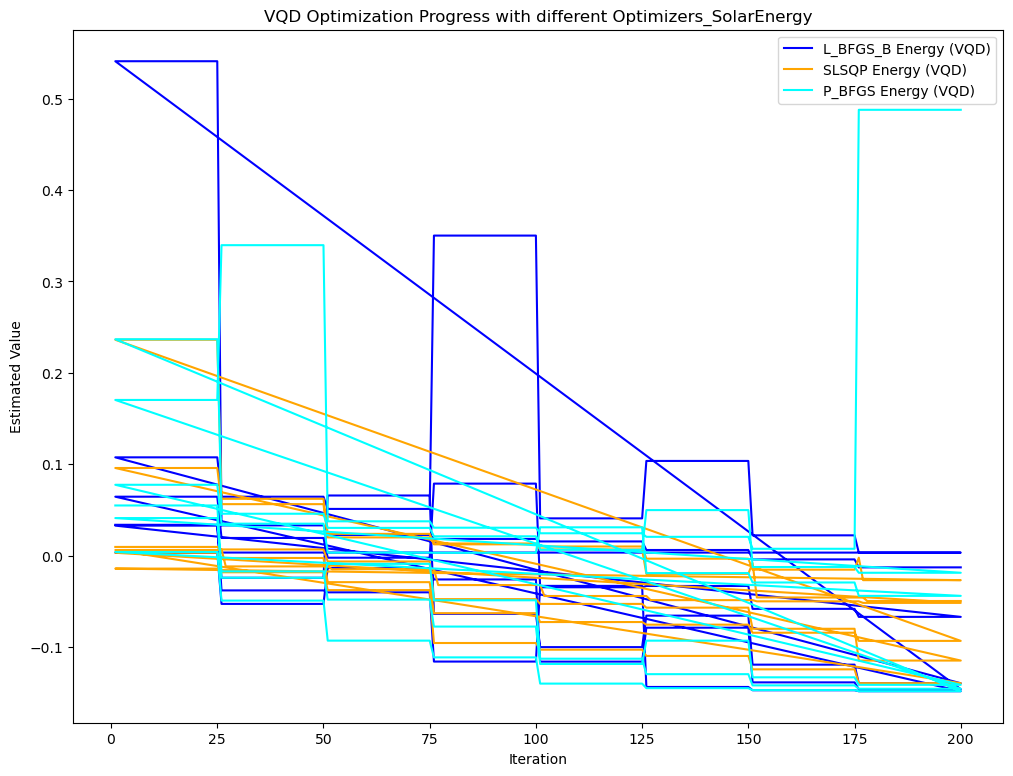

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms import VQD
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP, P_BFGS
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import *
from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25  # Reference temperature
G_ref = 1000  # Reference irradiance
R = 0.700  # Load resistance [internal resistance of 48v, 100Ah Lithium battery pack]
r_s = 18.15  # Internal resistance of two series connected panel [(V_oc-V_mpp)/(I_sc-I_mpp)]
k_V = -0.24  # Temperature coefficient for voltage
k_I = 0.04  # Temperature coefficient for current

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define the expanded Pauli operator based on the objective function
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)]) 
T_operator = SparsePauliOp.from_list([("IZII", 1)]) 
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)]) 
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)]) 

# Define the initial interaction operator
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

sampler = Sampler()
fidelity = ComputeUncompute(sampler)  # Fidelity computation

# Load IBM Quantum account and set backend
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend_name = 'ibm_sherbrooke'
backend = service.backend(backend_name)
options = Options(optimization_level=3)

# Define optimizers to use
optimizers = {'L_BFGS_B': L_BFGS_B(), 'SLSQP': SLSQP(), 'P_BFGS': P_BFGS()}
iteration_data = {optimizer_name: {'counts': [], 'values': [], 'steps': []} for optimizer_name in optimizers.keys()}

# Callback function for tracking progress
def callback(eval_count, params, value, meta, step, optimizer_name):
    if eval_count <= 200:
        iteration_data[optimizer_name]['counts'].append(eval_count)
        iteration_data[optimizer_name]['values'].append(value)
        iteration_data[optimizer_name]['steps'].append(step)

def create_custom_ansatz(num_qubits, reps=3):
    parameters = [Parameter(f'θ_{i}') for i in range(2 * num_qubits * reps)]
    circuit = QuantumCircuit(num_qubits)
    
    param_idx = 0
    for _ in range(reps):
        # Add rotation layers
        for qubit in range(num_qubits):
            circuit.ry(parameters[param_idx], qubit)
            param_idx += 1
            circuit.rz(parameters[param_idx], qubit)
            param_idx += 1
        
        # Add entanglement layer with controlled-Z (cz) gates
        for qubit in range(num_qubits - 1):
            circuit.cz(qubit, qubit + 1)
        circuit.cz(num_qubits - 1, 0)  # Wrap-around entanglement for circular structure
        
    return circuit, parameters

def flatten_params(params):
    """Flatten a nested structure (list or dictionary) into a single list of values."""
    flat_list = []
    if isinstance(params, dict):
        for value in params.values():
            flat_list.extend(flatten_params(value))
    elif isinstance(params, list):
        for item in params:
            flat_list.extend(flatten_params(item))
    else:
        flat_list.append(params)
    return flat_list

def run_vqd_with_deflation(optimizer, optimizer_name, num_qubits=4, reps=3, num_states=3):
    # Create the custom ansatz and parameters
    ansatz_circuit, parameters = create_custom_ansatz(num_qubits, reps)
    
    estimator = Estimator()
    eigenvalues = []
    modified_operator = operator  # Start with the initial Hamiltonian
    
    for _ in range(num_states):
        # Create VQD instance
        vqd_instance = VQD(estimator=estimator, ansatz=ansatz_circuit, optimizer=optimizer, fidelity=fidelity,
                           callback=lambda eval_count, params, value, meta, step: callback(eval_count, params, value, meta, step, optimizer_name))
        
        # Compute current eigenvalue
        result = vqd_instance.compute_eigenvalues(modified_operator)
        eigenvalues.append(result.eigenvalues[0].real)  # Save the lowest eigenvalue
        
        # Retrieve and flatten optimized parameters
        optimized_params = result.optimal_parameters  # Retrieve optimized parameters
        #print("Optimized Parameters (raw):", optimized_params)  # Debugging output
        
        # Fully flatten optimized_params and convert to floats
        optimized_params = flatten_params(optimized_params)
        #print("Optimized Parameters (fully flattened):", optimized_params)  # Debugging output after flattening
        optimized_params = [float(value) for value in optimized_params]
        
        # Create a parameter dictionary using individual Parameter instances
        param_dict = {param: value for param, value in zip(parameters, optimized_params)}
        
        # Bind optimized parameters directly to a new instance of the ansatz circuit
        eigenstate_circuit = ansatz_circuit.assign_parameters(param_dict)
        eigenstate = Statevector.from_instruction(eigenstate_circuit)  # Get the eigenstate from the circuit
        
        # Deflation term: calculate the outer product using the `to_operator` method
        deflation_term = SparsePauliOp.from_operator(eigenstate.to_operator())
        penalty_coefficient = 0.1  # Coefficient to control the strength of the deflation
        modified_operator = modified_operator + penalty_coefficient * deflation_term  # Add deflation term

    return eigenvalues
    
# Run VQD with Deflation for each optimizer
vqd_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqd_results[optimizer_name] = run_vqd_with_deflation(optimizer, optimizer_name)

# Plot results
colors = {'L_BFGS_B': 'blue', 'SLSQP': 'orange', 'P_BFGS': 'cyan'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    counts = data['counts']
    values = data['values']
    plt.plot(counts, values, label=f'{optimizer_name} Energy (VQD)', color=colors[optimizer_name])

plt.xlabel('Iteration')
plt.ylabel('Estimated Value')
plt.title('VQD Optimization Progress with different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqd_optimization_progress_solarenergy_deflation3.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = []
for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values):
    classical_power_outputs.append(power_output(V_oc, T, I_sc, G_theta))

# Print the final outputs
#for optimizer_name, eigenvalues in vqd_results.items():
    #quantum_max_power_output = eigenvalues[0] * impedance_factor  # Ground state energy for each optimizer
    #print(f"Maximized Power Output (Quantum with {optimizer_name} - Ground State): {quantum_max_power_output}")

#print("Maximized Power Output (Classical):", max(classical_power_outputs))